# Agent

With the above concepts clear, we can combine these into a [tool calling agent](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/)! 

The idea is simple: 

Above, we invoked our LLM, it chose to call a tool, and the tool executed, resuting a `ToolMessage`.

We just returned the raw `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` back to the LLM and let it either (1) call another tool or (2) respond directly.

This is the intution behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
`act` - call specific tools , `observe` - pass the tool outputs back to the LLM,  `reason` - about the tool output to decide what to do next 

This [general purpose cognitive architecture](https://blog.langchain.dev/planning-for-agents/) can applied to any set of tools. 
 
Let's create a few new tools, `add` and `divide`.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [4]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmatic on a set of inputs.")

# State
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Assistant
class Assistant:
    def __init__(self, llm_with_tools):
        """
        Initialize the Assistant with llm.
        """
        self.llm_with_tools = llm_with_tools

    def __call__(self, state: MessagesState, config):
        """
        Call method to invoke
        """
        # Get messages
        messages = state['messages']
        # Invoke chat model
        result = self.llm_with_tools.invoke([sys_msg] + messages)  
        return {"messages": result}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our LLM with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Critically, we connect the `Tools` node back to the `Assistant`, forming a loop!

* After the "assistant" node executes, `tools_condition` checks if the LLM's output is a tool call.
* If it is a tool call, the flow is directed to the "tools" node.
* If it's not a tool call, the flow is directed to END, terminating the process.

Overall, the loop will continue so long as the LLM decides to call specific tools.

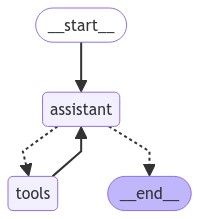

In [6]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(llm.bind_tools(tools)))
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
messages = [HumanMessage(content="Add 3 and 4, then multiple by 2, and finally divide by 5")]
messages = react_graph.invoke({"messages": messages})
messages['messages'][-1]

AIMessage(content='The result of the operations is 2.8.', response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 223, 'total_tokens': 235}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_3aa7262c27', 'finish_reason': 'stop', 'logprobs': None}, id='run-75c4d5a5-54a8-4e5f-be97-987af112b21f-0', usage_metadata={'input_tokens': 223, 'output_tokens': 12, 'total_tokens': 235})

In [8]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4, then multiple by 2, and finally divide by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_Ss97Tq0KirDdBSacsCjpnEyA)
 Call ID: call_Ss97Tq0KirDdBSacsCjpnEyA
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_bl7jb3TbQUrvAVhFfc5TkHxt)
 Call ID: call_bl7jb3TbQUrvAVhFfc5TkHxt
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_BV2U9pZv2oOukaeIJGupy1ek)
 Call ID: call_BV2U9pZv2oOukaeIJGupy1ek
  Args:
    a: 14
    b: 5
================================= Tool Message ====================

## LangGraph Studio

We can run our agent in Studio.

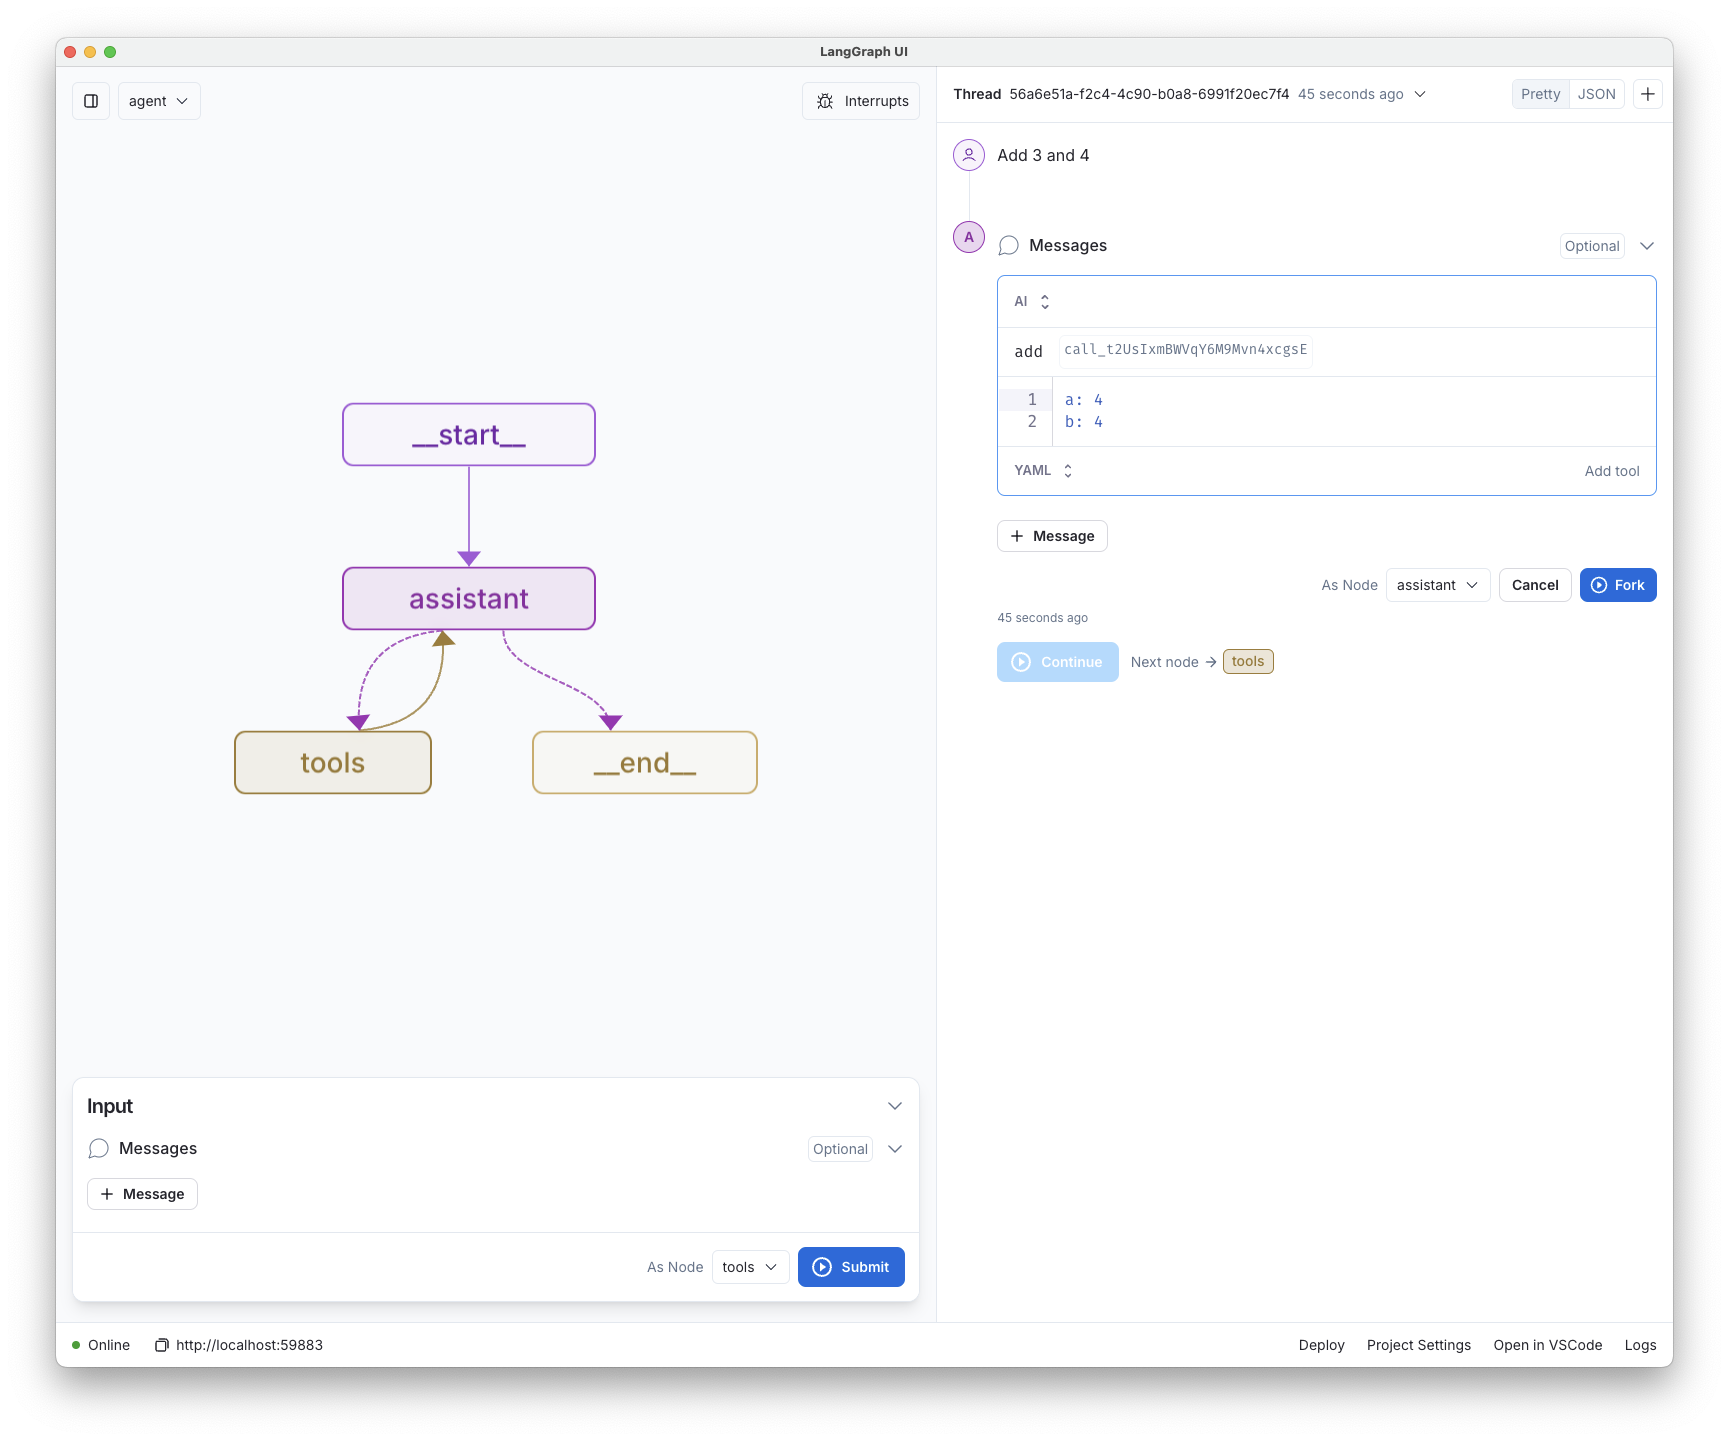

## Memory

Our agent can now use tools to answer user questions.

But it doesn't remember the context of previous interactions!

This limits its ability to have coherent, multi-turn conversations.

We can use [memory](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph has support for various types of memory.

One of the easiest to work with is simply `MemorySaver`, an in-memory key-value store for your graph state.

This allows the graph to save its state after each step.

In [9]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

`configurable` sets up a configuration with a thread ID.

This thread ID will maintain a specific conversation state.

When we stream, by default we will return a `key`-`value` pair of `node`-`state`.

We can simply only stream the state by passing `stream_mode="values"`.

In [10]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Hi there! Add 3 and 4")]

# Stream
events = react_graph_memory.stream(
    {"messages": messages}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_9oScRxXsKi8Oi3PPygu9W8Gf)
 Call ID: call_9oScRxXsKi8Oi3PPygu9W8Gf
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


The `Configuration Setup` with thread ID allows us to proceed from the previously logged state.

In [11]:
# Follow-up
messages = [HumanMessage(content="Take that output, and multiply it by 3!")]

# The config is the **second positional argument** to stream() or invoke()!
events = react_graph_memory.stream(
    {"messages": messages}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Take that output, and multiply it by 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_XDm4b4wdwlTrDgDgpqKXl6sE)
 Call ID: call_XDm4b4wdwlTrDgDgpqKXl6sE
  Args:
    a: 7
    b: 3
================================= Tool Message =================================
Name: multiply

21
================================== Ai Message ==================================

The result of multiplying 7 by 3 is 21.


The checkpointer allows the graph to maintain state between interactions.

The thread ID in the config ensures that multiple conversations can be managed separately.

By using the same thread ID in both interactions, the graph maintains context, allowing for coherent multi-turn conversations.

## Deployment

We've built 3 different cognitive architectures in LangGraph, and shown each in Studio:

What if we wanted to deploy any of these.

We can use [LangGraph Cloud](https://langchain-ai.github.io/langgraph/cloud/) for this.

In the `assistants` directory, [we can follow these instructions](https://langchain-ai.github.io/langgraph/cloud/quick_start/#test-the-graph-build-locally):

1) Confirm LangGraph API server runs locally: 
```
langgraph up
```

2) Then, [follow instructions](https://langchain-ai.github.io/langgraph/cloud/quick_start/#deploy-from-github-with-langgraph-cloud) to set up a deployment using GitHub.